# Experimenting with Maximum Likelihood Parameter Estimation (MLE)
Ball drop air

In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.integrate import odeint

## Generate data for a ball drop

In [2]:
def calculate_force(g, m, cd, u):
    return g*m - cd*u**2
    
def calculate_acceleration(g, cd, m, u):
    return calculate_force(g=g, m=m, cd=cd, u=u)/m

def ball_drop_air(states, t, g, m, cd):
    
    # states:
    # [x,u]
        
    x = states[0]
    u = states[1]
    dxdt = u
    
    dudt = calculate_acceleration(g=g, cd=cd, m=m, u=u)
    
    d_states_dt = np.array([dxdt,dudt])
    
    return d_states_dt

In [3]:
def simulate(x0,v0, t, g, m, cd):
    states_0 = [x0,v0]
    states = odeint(func = ball_drop_air,y0 = states_0,t = t,args=(g,m,cd))
    return states

In [4]:
df_parameters = pd.DataFrame()
parameters_correct = {
    'g':9.81,
    'm':2,
    'cd':0.05,  
    'x0':0,
    'v0':0,
}
parameters_correct = pd.Series(data=parameters_correct, name='correct')
df_parameters = df_parameters.append(parameters_correct)

In [5]:
t = np.linspace(0,5,1000)
states = simulate(t = t, **parameters_correct)

In [6]:
x = states[:,0]
xdot = states[:,1]

df = pd.DataFrame({'x':x, 'xdot':xdot}, index=t)
                   

In [30]:
df['xdotdot']=calculate_acceleration(**parameters_correct[['g','m','cd']],u=xdot)

Text(0, 0.5, 'dx2/dt [m/s]')

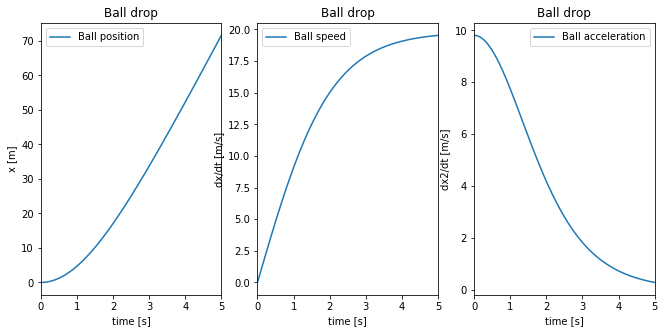

In [32]:
fig,axes = plt.subplots(ncols = 3)
fig.set_size_inches(11,5)
ax = axes[0]
df.plot(y='x',label = 'Ball position', ax=ax)
ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')


ax = axes[1]
df.plot(y='xdot',label = 'Ball speed', ax=ax)
ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('dx/dt [m/s]')

ax = axes[2]
df.plot(y='xdotdot',label = 'Ball acceleration', ax=ax)
ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('dx2/dt [m/s]')

## Ordinary Least Square fit (OLS)

## Add measurement noice

In [8]:
ϵ = np.random.normal(loc = 0.0, scale = 4.0, size = len(x))
df['x_measure'] = x + ϵ

In [10]:
df['xdot_measure'] = np.gradient(df['x_measure'],t)
df['xdotdot_measure']= np.gradient(df['xdot_measure'],t)

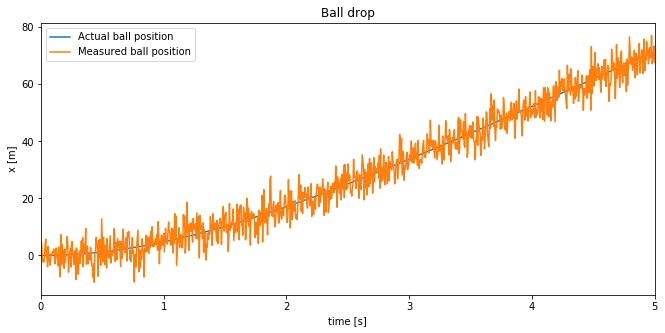

In [11]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)

df.plot(y='x', label = 'Actual ball position', ax=ax)
df.plot(y='x_measure', label = 'Measured ball position', ax=ax)

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()

In [12]:
from scipy.optimize import curve_fit
import inspect

In [13]:
def f(df,cd,g,m,x0,v0):
      
        
    states = simulate(x0, v0, t, g, m, cd)
    x = states[:,0]
    xdot = states[:,1]
    
    return x



In [36]:
def fit(f,df,ydata,p0=None):
    
    popt,pcov = curve_fit(f=f,xdata=df,ydata=ydata,p0=p0)
    
    signature = inspect.signature(f)
    parameter_names = list(signature.parameters.keys())[1:]
    
    parameter_values = list(popt)
    parameters = dict(zip(parameter_names, parameter_values))
    
    return parameters, pcov
    

In [37]:
signature = inspect.signature(f)
parameter_names = list(signature.parameters.keys())[1:]
    

guesses = {parameter_name:1 for parameter_name in parameter_names}
#guesses['g'] = 9.8
guesses['m'] = 2
p0 = []
for parameter_name in parameter_names:
    p0.append(guesses[parameter_name])

In [38]:
df.head()

,x,xdot,x_measure,xdot_measure,xdotdot_measure,xdotdot
0.000000,0.000000,0.000000,1.955486,542.116236,-133889.902100,9.810000
0.005005,0.000123,0.049099,4.668781,-128.003395,-120762.079320,9.809940
0.010010,0.000491,0.098197,0.674171,-666.713387,-15964.373020,9.809759
0.015015,0.001106,0.147295,-2.005027,-287.806928,62411.037186,9.809458
0.020020,0.001966,0.196390,-2.206779,-41.978280,48994.815367,9.809036


In [39]:
parameters, pcov = fit(f=f, df=df, ydata=df['x'], p0=p0)
parameters = pd.Series(data=parameters,name='exact')
df_parameters.loc[parameters.name] = parameters

c:\dev\rolldecay\venv\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [40]:
parameters_measure, pcov = fit(f=f, df=df, ydata=df['x_measure'], p0=p0)
parameters_measure = pd.Series(data=parameters_measure,name='measure')
df_parameters.loc[parameters_measure.name] = parameters_measure

## No sim solution

In [51]:
def f2(df,g,m,cd):
    xdot = df['xdot']
    return calculate_acceleration(g=g,cd=cd,m=m,u=xdot)
     

In [52]:
parameters_nosim, pcov = fit(f=f2, df=df, ydata=df['xdotdot'])
parameters_nosim = pd.Series(data=parameters_nosim,name='nosim')
df_parameters.loc[parameters_nosim.name] = parameters_nosim

## Minimize both position and velocity error

In [99]:
def f3(coeffs,df):
    
    cd,g,m,x0,v0 = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4]
        
    states = simulate(x0, v0, t, g, m, cd)
    
    x = states[:,0]
    xdot = states[:,1]
    x_error = (x - df['x']) / (df['x'].max() - df['x'].min())
    xdot_error = (xdot - df['xdot']) / (df['xdot'].max() - df['xdot'].min())
                
    return np.sum(x_error**2 + xdot_error**2)

In [101]:
from scipy.optimize import minimize

x0 = np.array([1,1,1,1,1])
result = minimize(fun=f3, x0=x0, args=(df,))


c:\dev\rolldecay\venv\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\dev\rolldecay\venv\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\dev\rolldecay\venv\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\dev\rolldecay\venv\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [102]:
result['x']

array([1.28944919e-01, 9.80999788e+00, 5.15779848e+00, 1.26247668e-06,
       1.07272515e-06])

In [105]:
parameters_pos_vel = {
    'cd' : result['x'][0],
    'g' : result['x'][1],
    'm' : result['x'][2],
    'x0' : result['x'][3],
    'v0' : result['x'][4],
}

In [106]:
parameters_pos_vel = pd.Series(data=parameters_pos_vel,name='pos_vel')
df_parameters.loc[parameters_pos_vel.name] = parameters_pos_vel

## Resimulat with models

In [107]:
results = df.copy()
results.drop(columns = ['x','x_measure'], inplace=True)
states = simulate(t=t,**parameters)
results['x'] = states[:,0]
results['xdot'] = states[:,1]

results_measure = df.copy()
results_measure.drop(columns = ['x','x_measure'], inplace=True)
states = simulate(t=t,**parameters_measure)
results_measure['x'] = states[:,0]
results_measure['xdot'] = states[:,1]

results_nosim = df.copy()
results_nosim.drop(columns = ['x','x_measure'], inplace=True)
states = simulate(t=t,**parameters_nosim,x0=0,v0=0)
results_nosim['x'] = states[:,0]
results_nosim['xdot'] = states[:,1]



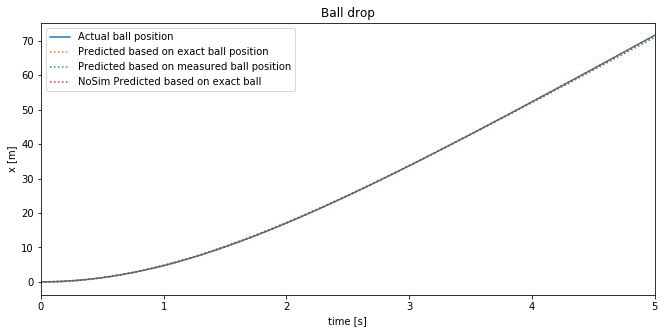

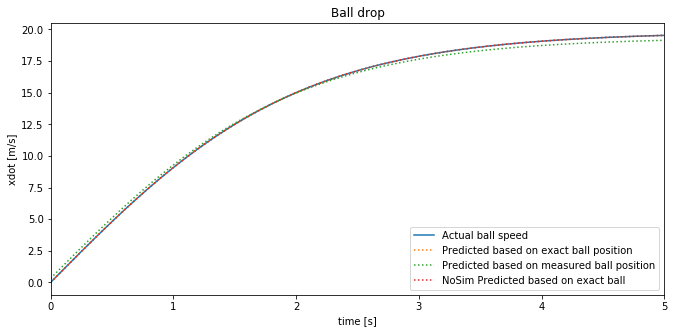

In [108]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)

df.plot(y='x', label = 'Actual ball position', ax=ax)
results.plot(y='x', label = 'Predicted based on exact ball position', style=':', ax=ax)
results_measure.plot(y='x', label = 'Predicted based on measured ball position', style=':', ax=ax)
results_nosim.plot(y='x', label = 'NoSim Predicted based on exact ball', style=':', ax=ax)

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()


fig,ax = plt.subplots()
fig.set_size_inches(11,5)

df.plot(y='xdot', label = 'Actual ball speed', ax=ax)
results.plot(y='xdot', label = 'Predicted based on exact ball position', style=':', ax=ax)
results_measure.plot(y='xdot', label = 'Predicted based on measured ball position', style=':', ax=ax)
results_nosim.plot(y='xdot', label = 'NoSim Predicted based on exact ball', style=':', ax=ax)

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('xdot [m/s]')
ax.legend()

In [109]:
results['x_error'] = df['x'] - results['x']
results['xdot_error'] = df['xdot'] - results['xdot']

results_measure['x_error'] = df['x'] - results_measure['x']
results_measure['xdot_error'] = df['xdot'] - results_measure['xdot']



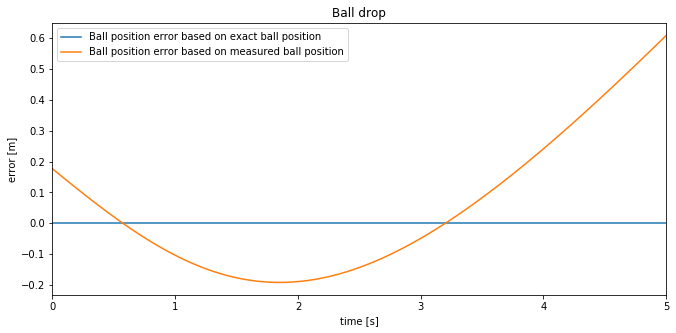

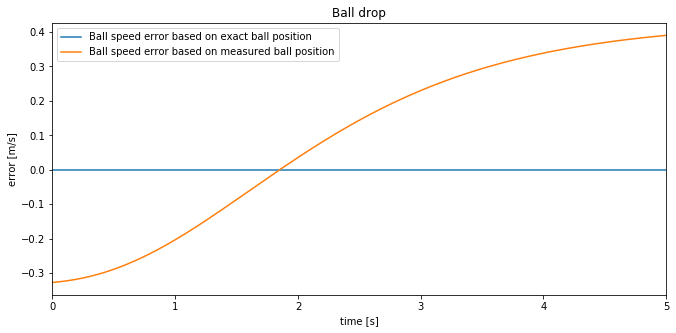

In [110]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)

results.plot(y='x_error', label = 'Ball position error based on exact ball position', ax=ax)
results_measure.plot(y='x_error', label = 'Ball position error based on measured ball position', ax=ax)

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('error [m]')
ax.legend()


fig,ax = plt.subplots()
fig.set_size_inches(11,5)

results.plot(y='xdot_error', label = 'Ball speed error based on exact ball position', ax=ax)
results_measure.plot(y='xdot_error', label = 'Ball speed error based on measured ball position', ax=ax)

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('error [m/s]')
ax.legend()

## Parameters

In [111]:
df_parameters.fillna(0, inplace=True)
df_parameters

,cd,g,m,v0,x0
correct,0.050000,9.810000,2.000000,0.000000e+00,0.000000e+00
exact,0.154083,9.810001,6.163325,-6.992066e-07,7.399735e-08
measure,0.193511,9.782899,7.429443,3.266779e-01,-1.765377e-01
nosim,0.158437,9.810000,6.337465,0.000000e+00,0.000000e+00
pos_vel,0.128945,9.809998,5.157798,1.072725e-06,1.262477e-06


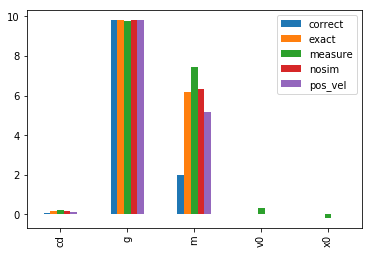

In [112]:
df_parameters.transpose().plot(kind='bar')

In [113]:
df_paramters_compare = df_parameters/df_parameters.loc['correct']

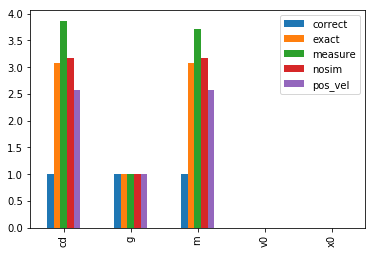

In [114]:
df_paramters_compare.transpose().plot(kind='bar')